# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew


from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
# azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
# customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [3]:
# pickle/serialize df to file 
# azdias.to_pickle('azdias.pickle')
# customers.to_pickle('customers.pickle')

In [4]:
# load pickled file
azdias = pd.read_pickle('azdias.pickle')
customers = pd.read_pickle('customers.pickle')

In [5]:
print("General Population DF shape: {}".format(azdias.shape))

General Population DF shape: (891221, 366)


In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
print("Customers DF shape: {}".format(azdias.shape))

Customers DF shape: (891221, 366)


In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

# Preprocessing

#### 1.) Assess missing data in columns

**Start by assessing the DIAS_Attributes_Values file for missing key values and create missing keys dictionary**

**Clean "unknown" transaction data**

In [10]:
unknown_keys_dict = {}
attribute_values = pd.read_csv("./DIAS_Attributes_Values_2017.csv", sep=',')

In [11]:
unknown_keys = attribute_values[attribute_values["Meaning"].isin(["unknown", "unknown / no main age detectable"])]

In [12]:
for _, row in unknown_keys.iterrows():
    key = row["Attribute"]
    unknown_keys_dict[key] = row["Value"].split(", ")

In [13]:
print(unknown_keys_dict)

{'AGER_TYP': ['-1'], 'ALTERSKATEGORIE_GROB': ['-1', '0'], 'ALTER_HH': ['0'], 'ANREDE_KZ': ['-1', '0'], 'BALLRAUM': ['-1'], 'BIP_FLAG': ['-1'], 'CAMEO_DEUG_2015': ['-1'], 'CAMEO_DEUINTL_2015': ['-1'], 'CJT_GESAMTTYP': ['0'], 'D19_KK_KUNDENTYP': ['-1'], 'EWDICHTE': ['-1'], 'FINANZTYP': ['-1'], 'FINANZ_ANLEGER': ['-1'], 'FINANZ_HAUSBAUER': ['-1'], 'FINANZ_MINIMALIST': ['-1'], 'FINANZ_SPARER': ['-1'], 'FINANZ_UNAUFFAELLIGER': ['-1'], 'FINANZ_VORSORGER': ['-1'], 'GEBAEUDETYP': ['-1', '0'], 'GEOSCORE_KLS7': ['-1', '0'], 'HAUSHALTSSTRUKTUR': ['-1', '0'], 'HEALTH_TYP': ['-1'], 'HH_EINKOMMEN_SCORE': ['-1', '0'], 'INNENSTADT': ['-1'], 'KBA05_ALTER1': ['-1', '9'], 'KBA05_ALTER2': ['-1', '9'], 'KBA05_ALTER3': ['-1', '9'], 'KBA05_ALTER4': ['-1', '9'], 'KBA05_ANHANG': ['-1', '9'], 'KBA05_ANTG1': ['-1'], 'KBA05_ANTG2': ['-1'], 'KBA05_ANTG3': ['-1'], 'KBA05_ANTG4': ['-1'], 'KBA05_AUTOQUOT': ['-1', '9'], 'KBA05_BAUMAX': ['-1', '0'], 'KBA05_CCM1': ['-1', '9'], 'KBA05_CCM2': ['-1', '9'], 'KBA05_CCM3': ['

**Clean "no transaction known" & "no transactions known" data where its value=0**

In [14]:
no_transaction_one = {}
no_transaction_two = {}

In [15]:
no_transaction_keys_1 = attribute_values[attribute_values["Meaning"].isin(["no transaction known", "no transactions known"])]

In [16]:
for _, row in no_transaction_keys_1.iterrows():
    key = row["Attribute"]
    no_transaction_one[key] = row["Value"].split(", ")

**Remove "_RZ" from attributes name**

In [17]:
no_transaction_one_list = no_transaction_one.keys()

In [18]:
if key in no_transaction_one_list:
    new_key = key.replace("RZ", "")
    no_transaction_one[new_key] = ["0"]
else:
    no_transaction_one[key] = ["0"]

In [19]:
print(no_transaction_one)

{'D19_BANKEN_ANZ_12': ['0'], 'D19_BANKEN_ANZ_24': ['0'], nan: ['10'], 'D19_BANKEN_DIREKT_RZ': ['0'], 'D19_BANKEN_GROSS_RZ': ['0'], 'D19_BANKEN_LOKAL_RZ': ['0'], 'D19_BANKEN_REST_RZ': ['0'], 'D19_BEKLEIDUNG_GEH_RZ': ['0'], 'D19_BEKLEIDUNG_REST_RZ': ['0'], 'D19_BILDUNG_RZ': ['0'], 'D19_BIO_OEKO_RZ': ['0'], 'D19_BUCH_RZ': ['0'], 'D19_DIGIT_SERV_RZ': ['0'], 'D19_DROGERIEARTIKEL_RZ': ['0'], 'D19_ENERGIE_RZ': ['0'], 'D19_FREIZEIT_RZ': ['0'], 'D19_GARTEN_RZ': ['0'], 'D19_GESAMT_ANZ_12': ['0'], 'D19_GESAMT_ANZ_24': ['0'], 'D19_HANDWERK_RZ': ['0'], 'D19_HAUS_DEKO_RZ': ['0'], 'D19_KINDERARTIKEL_RZ': ['0'], 'D19_KOSMETIK_RZ': ['0'], 'D19_LEBENSMITTEL_RZ': ['0'], 'D19_LOTTO_RZ': ['0'], 'D19_NAHRUNGSERGAENZUNG_RZ': ['0'], 'D19_RATGEBER_RZ': ['0'], 'D19_REISEN_RZ': ['0'], 'D19_SAMMELARTIKEL_RZ': ['0'], 'D19_SCHUHE_RZ': ['0'], 'D19_SONSTIGE_RZ': ['0'], 'D19_TECHNIK_RZ': ['0'], 'D19_TELKO_ANZ_12': ['0'], 'D19_TELKO_ANZ_24': ['0'], 'D19_TELKO_MOBILE_RZ': ['0'], 'D19_TELKO_REST_RZ': ['0'], 'D19_TIERARTI

**Clean "no transaction known" & "no transactions known" data where its value=10**

In [20]:
no_transaction_keys_2 = attribute_values[attribute_values["Meaning"].isin(["highest activity within the last 12 months"])]

In [21]:
for _, row in no_transaction_keys_2.iterrows():
    key = row["Attribute"]
    no_transaction_two[key] = ['10']

In [22]:
print(no_transaction_two)

{'D19_BANKEN_DATUM': ['10'], 'D19_BANKEN_OFFLINE_DATUM': ['10'], 'D19_BANKEN_ONLINE_DATUM': ['10'], 'D19_GESAMT_DATUM': ['10'], 'D19_GESAMT_OFFLINE_DATUM': ['10'], 'D19_GESAMT_ONLINE_DATUM': ['10'], 'D19_TELKO_DATUM': ['10'], 'D19_TELKO_OFFLINE_DATUM': ['10'], 'D19_TELKO_ONLINE_DATUM': ['10'], 'D19_VERSAND_DATUM': ['10'], 'D19_VERSAND_OFFLINE_DATUM': ['10'], 'D19_VERSAND_ONLINE_DATUM': ['10']}


**Merge "unknown" and "no transaction known" dictionary**

In [23]:
missing_keys_dict = { **unknown_keys_dict, **no_transaction_one, **no_transaction_two }

**For attributes with missing codes, manually add codes from attributes that are similar to it**

In [24]:
a = list(attribute_values["Attribute"].dropna())
#print(a)

In [25]:
b = list(azdias.columns)
#print(b)

In [26]:
# Attributes that are in azdias columns dataset but not explained in DIAS_Attributes_Values.csv
c = [elem for elem in b if elem not in a]
#print(c)

In [27]:
# Attributes that are explained in DIAS_Attributes_Values.csv but are not in azdias columns
d = [elem for elem in a if elem not in b]
#print(d)

In [28]:
# Manually add missing codes from other similar attributes
missing_keys_dict["CAMEO_DEU_2015"] = ['XX'] # there is no missing value code assigned for this attribute
missing_keys_dict["CAMEO_DEUG_2015"] = ['X', 'XX'] # there is no missing value code assigned for this attribute
missing_keys_dict["CAMEO_INTL_2015"] = ['XX'] # there is no missing value code assigned for this attribute
missing_keys_dict["CAMEO_INTL_2015"] = missing_keys_dict["CAMEO_DEUINTL_2015"] # assign similar value code to CAMEO_INTL_2015 
missing_keys_dict["GEBURTSJAHR"] = ['0'] # there is no missing value code assigned for this attribute as it records the data year of birth
missing_keys_dict["KBA13_CCM_1401_2500"] = missing_keys_dict["KBA13_CCM_1400_2500"] # assign similar value code to KBA13_CCM_1401_2500 because value code is not explained in DIAS_Attributes_Values.csv
missing_keys_dict["KBA13_BAUMAX"] = missing_keys_dict["KBA05_BAUMAX"] # assign similar value code to KBA13_CCM_1401_2500 because value code is not explained in DIAS_Attributes_Values.csv
missing_keys_dict["KBA13_ANTG1"] = missing_keys_dict["KBA05_ANTG1"] # assign similar value code to KBA13_CCM_1401_2500 because value code is not explained in DIAS_Attributes_Values.csv
missing_keys_dict["KBA13_ANTG2"] = missing_keys_dict["KBA05_ANTG2"] # assign similar value code to KBA13_CCM_1401_2500 because value code is not explained in DIAS_Attributes_Values.csv
missing_keys_dict["KBA13_ANTG3"] = missing_keys_dict["KBA05_ANTG3"] # assign similar value code to KBA13_CCM_1401_2500 because value code is not explained in DIAS_Attributes_Values.csv
missing_keys_dict["KBA13_ANTG4"] = missing_keys_dict["KBA05_ANTG4"] # assign similar value code to KBA13_CCM_1401_2500 because value code is not explained in DIAS_Attributes_Values.csv   

In [29]:
print(missing_keys_dict)

{'AGER_TYP': ['-1'], 'ALTERSKATEGORIE_GROB': ['-1', '0'], 'ALTER_HH': ['0'], 'ANREDE_KZ': ['-1', '0'], 'BALLRAUM': ['-1'], 'BIP_FLAG': ['-1'], 'CAMEO_DEUG_2015': ['X', 'XX'], 'CAMEO_DEUINTL_2015': ['-1'], 'CJT_GESAMTTYP': ['0'], 'D19_KK_KUNDENTYP': ['-1'], 'EWDICHTE': ['-1'], 'FINANZTYP': ['-1'], 'FINANZ_ANLEGER': ['-1'], 'FINANZ_HAUSBAUER': ['-1'], 'FINANZ_MINIMALIST': ['-1'], 'FINANZ_SPARER': ['-1'], 'FINANZ_UNAUFFAELLIGER': ['-1'], 'FINANZ_VORSORGER': ['-1'], 'GEBAEUDETYP': ['-1', '0'], 'GEOSCORE_KLS7': ['-1', '0'], 'HAUSHALTSSTRUKTUR': ['-1', '0'], 'HEALTH_TYP': ['-1'], 'HH_EINKOMMEN_SCORE': ['-1', '0'], 'INNENSTADT': ['-1'], 'KBA05_ALTER1': ['-1', '9'], 'KBA05_ALTER2': ['-1', '9'], 'KBA05_ALTER3': ['-1', '9'], 'KBA05_ALTER4': ['-1', '9'], 'KBA05_ANHANG': ['-1', '9'], 'KBA05_ANTG1': ['-1'], 'KBA05_ANTG2': ['-1'], 'KBA05_ANTG3': ['-1'], 'KBA05_ANTG4': ['-1'], 'KBA05_AUTOQUOT': ['-1', '9'], 'KBA05_BAUMAX': ['-1', '0'], 'KBA05_CCM1': ['-1', '9'], 'KBA05_CCM2': ['-1', '9'], 'KBA05_CCM3

**Produce an array of number of missing values for each column**

In [30]:
def get_missing_by_column(df):
    '''
    Determine the number of NaN or missing values for each column and returns an array of this number
    Input:
        df (dataframe): The dataframe for which the evaluation will be made
    Output:
        col_missing_value (array): An array of values representing missing values for each column
    '''
    col_missing_value = []
    for col in azdias.columns:
        try:
            col_missing_value.append(azdias[col].isnull().value_counts()[1])
        except:
            col_missing_value.append(0)
    return col_missing_value

In [31]:
initial_missing = get_missing_by_column(azdias)

In [32]:
print(initial_missing)

[0, 0, 73499, 73499, 810163, 861722, 885051, 890016, 262947, 93148, 97008, 73499, 73499, 93148, 73499, 97216, 93740, 98979, 98979, 98979, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 0, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 257113, 0, 0, 0, 257113, 257113, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 93148, 93148, 73499, 93740, 654153, 0, 0, 0, 0, 0, 0, 0, 93155, 93148, 93155, 0, 97274, 4854, 0, 0, 107602, 18348, 93740, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 93148, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 93148, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 13332

**Convert missing value key to NaN**

In [33]:
def convert_keys_to_nan(df, keys_dict):
    '''
    Replace missing value with np.NaN for missing value keys in the missing keys dictionary
    Input:
        df (dataframe):
        keys_dict (dictionary): Dictionary of attributes as keys with missing value that needs to be converted to np.NaN
    Output:
        None
    '''
    for attribute in keys_dict:
        if attribute in azdias.columns:
            keys_values = keys_dict[attribute]
            for value in keys_values:
                if value == 'X' or value == 'XX':
                    value = str(value)
                else:
                    value = int(value)
                df[attribute].replace(value, np.NaN, inplace=True)

In [34]:
convert_keys_to_nan(azdias, missing_keys_dict)

**Check how much missing data there is in each column**

In [35]:
def create_missing_info_df(df, initial_missing=None):
    '''
    Build a missing info dataframe where each row is an attribute and the columns will show 
    initial missing values (obtained from isnull() function), final missing values (obtained
    from encoding to np.NaN) and percentage of missing values.
    Input:
        df (dataframe): dataframe from which missing info is created
        initial_missing (array): An array of values representing missing values for each column
    Output:
        sorted_missing_info (dataframe): Dataframe showing attributes in each row with its
        corresponding initial missing, final missing and percentage missing values; sorted in 
        descending order.
    '''
    missing_info = pd.DataFrame(data=azdias.columns, columns=["Attribute"])
    
    if initial_missing != None:
        missing_info["initial_missing"] = initial_missing
        
    missing_info["final_missing"] = get_missing_by_column(df)
    total = df.shape[0]
    
    # calculate percent of total missing value by attribute 
    missing_info["%_missing"] = missing_info["final_missing"] / total * 100
    
    # dataframe of missing attributes sorted from lowest to highest
    sorted_missing_info = missing_info.sort_values(by="final_missing", ascending=False)
    
    return sorted_missing_info

In [36]:
sorted_missing_info = create_missing_info_df(azdias, initial_missing)
print(sorted_missing_info.round(decimals=1)[:30])

                     Attribute  initial_missing  final_missing  %_missing
7                  ALTER_KIND4           890016         890016       99.9
349                   TITEL_KZ            73499         889061       99.8
6                  ALTER_KIND3           885051         885051       99.3
76      D19_TELKO_ONLINE_DATUM                0         883018       99.1
34    D19_BANKEN_OFFLINE_DATUM                0         871535       97.8
5                  ALTER_KIND2           861722         861722       96.7
71            D19_TELKO_ANZ_12                0         857990       96.3
28           D19_BANKEN_ANZ_12                0         831734       93.3
72            D19_TELKO_ANZ_24                0         826208       92.7
87            D19_VERSI_ANZ_12                0         821289       92.2
75     D19_TELKO_OFFLINE_DATUM                0         819114       91.9
4                  ALTER_KIND1           810163         810163       90.9
29           D19_BANKEN_ANZ_24        

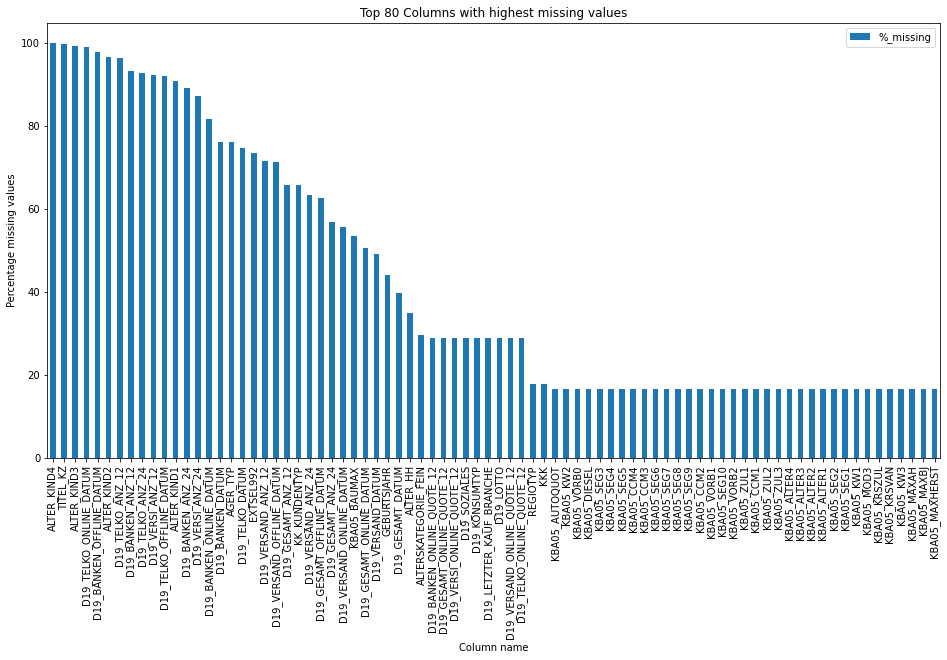

In [37]:
ax = sorted_missing_info[:80].plot("Attribute", "%_missing", kind="bar", figsize=(16, 8), 
                                   title="Top 80 Columns with highest missing values")
ax.set_xlabel("Column name")
ax.set_ylabel("Percentage missing values")
ax.figure.savefig('top_missing.png', dpi=500);

**Drop columns with more than 30% missing data**

In [38]:
deleted_columns_one = sorted_missing_info[sorted_missing_info["%_missing"]>30]["Attribute"].values
print(len(deleted_columns_one))
print(list(deleted_columns_one))
print(sorted_missing_info[sorted_missing_info["%_missing"]>30]["%_missing"].values.round(2))

33
['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2', 'D19_TELKO_ANZ_12', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_TELKO_OFFLINE_DATUM', 'ALTER_KIND1', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'AGER_TYP', 'D19_TELKO_DATUM', 'EXTSEL992', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 'KBA05_BAUMAX', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'GEBURTSJAHR', 'D19_GESAMT_DATUM', 'ALTER_HH']
[99.86 99.76 99.31 99.08 97.79 96.69 96.27 93.33 92.71 92.15 91.91 90.9
 89.1  87.19 81.57 76.11 76.02 74.71 73.4  71.58 71.16 65.62 65.6  63.26
 62.67 56.7  55.48 53.47 50.6  49.13 44.02 39.74 34.81]


Total columns with more than 30% missing data is 33 columns. These 33 attributes will be dropped from the dataframe.

**Additional columns to drop**

By going through the AZDIAS columns and comparing them to the DIAS_Attribute_Values file, we ensure that columns in the AZDIAS data are found in the DIAS_Attribute_Values file. We also check for columns that are a repeat or similar to other columns, has many zero values and too many categories. <br>

Add additional columns to remove: <br>
LNR : Identifier that does not contribute to analysis. <br>
ANZ_HH_TITEL : Too many zero values. <br>
ANZ_KINDER : Too many categories. 11 categories. <br>
ANZ_TITEL : Too many zero values. <br>
CAMEO_DEU_2015 : Too many categories. 44 categories. <br>
GEBAEUDETYP : Repeat of GEBAEUDETYP_RASTER. <br>
KBA05_MODTEMP : Repeat of KBA05_HERSTTEMP. <br>
LP_FAMILIE_FEIN : Repeat of LP_FAMILY_GROB. <br>
LP_LEBENSPHASE_FEIN : Too many categories and repeat of other columns. 40 categories. <br>
LP_LEBENSPHASE_GROB : Too many categories and repeat of other columns. 12 categories. <br>
LP_STATUS_FEIN : Almost similar to LP_STATUS_GROB. <br>
PLZ8_ANTG1 : Almost similar to PLZ8_BAUMAX. <br>
PLZ8_ANTG2 : Almost similar to PLZ8_BAUMAX. <br>
PLZ8_ANTG3 : Almost similar to PLZ8_BAUMAX. <br>
PLZ8_ANTG4 : Almost similar to PLZ8_BAUMAX. <br>
VERDICHTUNGSRAUM : Too many categories. 45 categories. <br>
VK_DHT4A : Too many categories. 11 categories. <br>
VK_DISTANZ : Too many categories. 11 categories. <br>
VK_ZG11 : Too many categories. 11 categories. <br>
ALTERSKATEGORIE_FEIN : Attribute is unknown. <br>
D19_TELKO_ONLINE_QUOTE_12 : Attribute is unknown. Too many zero values. <br>
D19_LETZTER_KAUF_BRANCHE : Attribute is unknown. <br>
D19_VERSI_ONLINE_QUOTE_12 : Attribute is unknown. Too many zero values. <br>

In [39]:
deleted_columns_two = ['LNR', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'CAMEO_DEU_2015',
                       'GEBAEUDETYP', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
                       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PLZ8_ANTG1',
                       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'VERDICHTUNGSRAUM', 'VK_DHT4A',
                       'VK_DISTANZ', 'VK_ZG11', 'ALTERSKATEGORIE_FEIN', 'D19_TELKO_ONLINE_QUOTE_12',
                       'D19_LETZTER_KAUF_BRANCHE', 'D19_VERSI_ONLINE_QUOTE_12']

**List all columns to be dropped**

In [40]:
deleted_columns = list(deleted_columns_one) + deleted_columns_two
print(len(deleted_columns))
print(deleted_columns)

56
['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2', 'D19_TELKO_ANZ_12', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_TELKO_OFFLINE_DATUM', 'ALTER_KIND1', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'AGER_TYP', 'D19_TELKO_DATUM', 'EXTSEL992', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 'KBA05_BAUMAX', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'GEBURTSJAHR', 'D19_GESAMT_DATUM', 'ALTER_HH', 'LNR', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'CAMEO_DEU_2015', 'GEBAEUDETYP', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'VERDICHTUNGSRAUM', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'ALTERSKATEGORIE_FEIN', 'D19_TELKO_O

In [41]:
print("AZDIAS shape in original dataframe: {}".format(azdias.shape))
azdias_reduced = azdias.drop(deleted_columns, axis=1)
print("AZDIAS shape with columns dropped: {}".format(azdias_reduced.shape))

AZDIAS shape in original dataframe: (891221, 366)
AZDIAS shape with columns dropped: (891221, 310)


#### 2.) Assess missing data in rows

In [42]:
# Calculate the number of missing value for each row
azdias_reduced["n_missing"] = azdias_reduced.isnull().sum(axis=1)

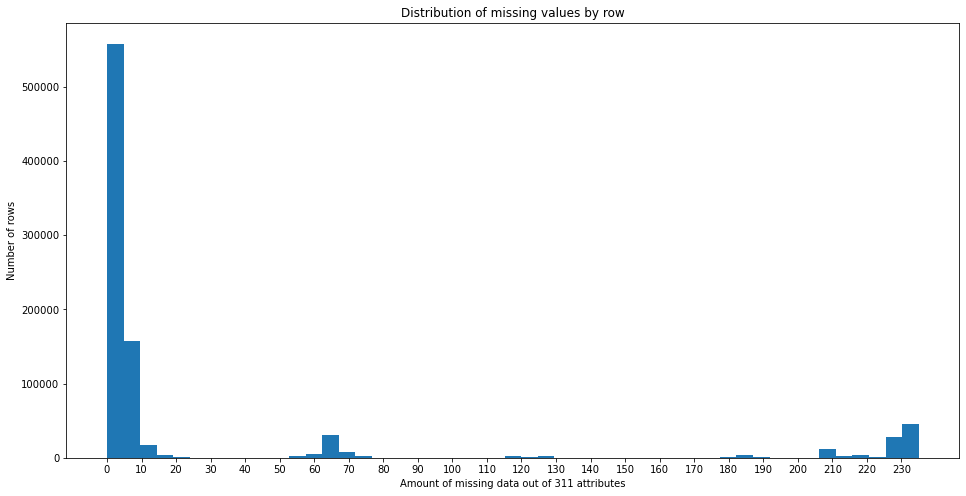

In [43]:
plt.figure(figsize=(16, 8))
plt.hist(azdias_reduced["n_missing"], bins=np.linspace(min(azdias_reduced["n_missing"]), max(azdias_reduced["n_missing"])+1))
plt.xticks(np.arange(min(azdias_reduced["n_missing"]), max(azdias_reduced["n_missing"])+1, 10))
plt.ylabel("Number of rows")
plt.xlabel("Amount of missing data out of {} attributes".format(azdias_reduced.shape[1]))
plt.title("Distribution of missing values by row")
plt.savefig('row_missing.png', dpi=500);

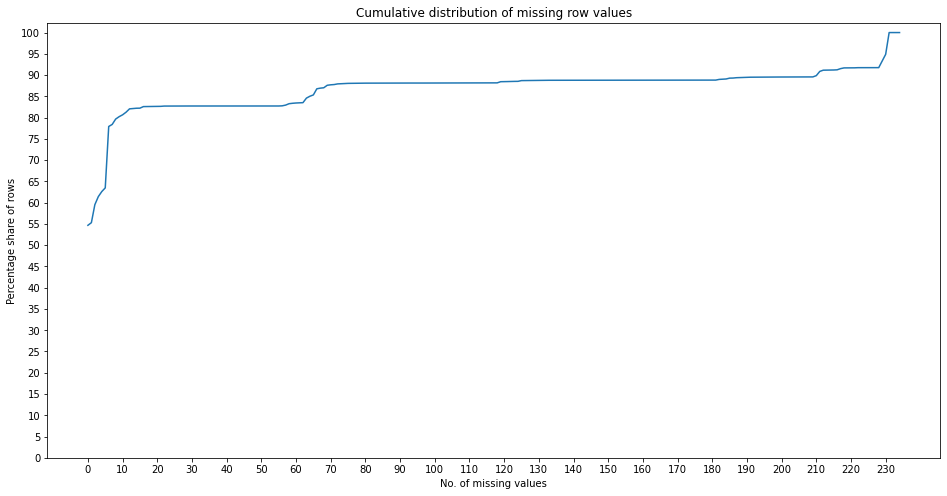

In [44]:
x = (azdias_reduced["n_missing"].value_counts().sort_index().cumsum()/len(azdias)) * 100

plt.figure(figsize=(16, 8))
plt.plot(x)

plt.yticks(np.arange(0, 100+5, 5))
plt.xticks(np.arange(min(x.index), max(x.index)+1, 10))

plt.ylabel("Percentage share of rows")
plt.xlabel("No. of missing values")
plt.title("Cumulative distribution of missing row values")
plt.savefig("cum_dist_missing_rows.png", dpi=500);

In [45]:
print("Percentage of data kept: \n", x[0:30])

Percentage of data kept: 
 0     54.673869
1     55.290439
2     59.520702
3     61.416080
4     62.605459
5     63.472023
6     77.910978
7     78.394360
8     79.655102
9     80.218711
10    80.656874
11    81.272883
12    82.057649
13    82.139671
14    82.203292
15    82.220684
16    82.588382
17    82.598368
18    82.616209
19    82.629561
20    82.640782
21    82.648299
22    82.711583
23    82.714276
24    82.715398
25    82.718877
26    82.722131
27    82.724711
28    82.727741
29    82.727853
Name: n_missing, dtype: float64


The figure above shows us the percentage share of rows with X no. of missing values. 

We shall keep rows with less than 26 missing values. This means 82% share of rows data will be retained. This is where the percentage of rows/data kept plateaus. We shall use this threshold to drop the rows with missing values.

In [46]:
# Keep rows with missing rows that is less than 26 missing attributes
azdias_row_reduced = azdias_reduced[azdias_reduced["n_missing"] < 26].drop("n_missing", axis=1)
print(azdias_row_reduced.shape)

(737208, 310)


#### 3.) Clean and perform feature engineering

Summarizing from above, the steps performed to clean data are condensed into a clean_data helper function.

Further, the following attributes require feature engineering before the dataframe can be used for analysis.

Attributes that need feature engineering:
['OST_WEST_KZ', 'EINGEFUEGT_AM', 'CAMEO_DEUG_2015']

In [47]:
def clean_data(df, missing_keys_dict, test_data=False):
    '''
    Clean the dataframe by performing column, row drops and feature engineering.
    Input:
        df (dataframe): original dataframe to be cleaned
        missing_keys_dict (dictionary): dictionary of attributes and its missing keys
        test_data (boolean): test data, if dataframe is not a test data then default is False
    Output:
        df_cleaned (dataframe): dataframe that has been cleaned
    
    '''
    
    # COLUMN DROP
    # convert missing value codes into NaNs
    convert_keys_to_nan(df, missing_keys_dict)
    # Drop columns with more than 30% of missing values
    deleted_columns_1 = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
                         'ALTER_KIND2', 'D19_TELKO_ANZ_12', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 
                         'D19_TELKO_OFFLINE_DATUM', 'ALTER_KIND1', 'D19_BANKEN_ANZ_24', 'D19_VERSI_ANZ_24', 
                         'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'AGER_TYP', 'D19_TELKO_DATUM', 'EXTSEL992', 
                         'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 
                         'D19_VERSAND_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 
                         'KBA05_BAUMAX', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'GEBURTSJAHR', 'D19_GESAMT_DATUM', 
                         'ALTER_HH']   
    # Drop more columns with unknown / repeated / attributes or has many zero values
    deleted_columns_2 = ['LNR', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'CAMEO_DEU_2015',
                         'GEBAEUDETYP', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
                         'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PLZ8_ANTG1',
                         'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'VERDICHTUNGSRAUM', 'VK_DHT4A',
                         'VK_DISTANZ', 'VK_ZG11', 'ALTERSKATEGORIE_FEIN', 'D19_TELKO_ONLINE_QUOTE_12',
                         'D19_LETZTER_KAUF_BRANCHE', 'D19_VERSI_ONLINE_QUOTE_12']

    # Perform column drop

    deleted_columns = list(deleted_columns_1) + list(deleted_columns_2)
    df_cleaned = df.drop(deleted_columns,axis=1)
    
    
    # ROW DROP
    # Drop rows with more than 26 missing attributes if it is not a testing data, skip this step if it is a test data
    df_cleaned['n_missing'] = df_cleaned.isnull().sum(axis=1)
    
    try:
        df_cleaned = df_cleaned.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'], axis=1)
    except:
        pass
    
    if not test_data:
        # Remove rows with more than 26 missing attributes
        df_cleaned = df_cleaned[df_cleaned["n_missing"] < 26].drop("n_missing", axis=1)
    else:
        df_cleaned = df_cleaned.drop("n_missing", axis=1)
    
    
    # FEATURE ENGINEERING OF ATTRIBUTES

    # OST_WEST_KZ -> Change attribute values O -> 0, W -> 1
    # print("Reencode OST_WEST_KZ attribute")
    df_cleaned['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)
    
    # EINGEFUEGT_AM -> Change to year format
    # print("Change EINGEFUEGT_AM to year")
    df_cleaned["EINGEFUEGT_AM"] = pd.to_datetime(df_cleaned["EINGEFUEGT_AM"], format='%Y/%m/%d %H:%M')
    df_cleaned["EINGEFUEGT_AM"] = df_cleaned["EINGEFUEGT_AM"].dt.year
    
    # CAMEO_DEUG_2015 -> Change object type to numeric type
    df_cleaned["CAMEO_DEUG_2015"] = pd.to_numeric(df_cleaned["CAMEO_DEUG_2015"])
     
    return df_cleaned

In [48]:
azdias_cleaned = clean_data(azdias, missing_keys_dict)
azdias_cleaned.shape

(737208, 310)

In [49]:
azdias_cleaned.dtypes.value_counts()

float64    244
int64       65
object       1
dtype: int64

In [50]:
customers_cleaned = clean_data(customers, missing_keys_dict)
customers_cleaned.shape

(134245, 310)

In [51]:
customers_cleaned.dtypes.value_counts()

float64    244
int64       65
object       1
dtype: int64

#### 4.) Impute, transform and standardize features

We shall now classify attributes type and impute the data according to the type of attribute:

1.) skewed continuous - These are datasets that are continuous numbers. For example, the number of people in a household and number of cars. Highly skewed continuous datasets have to be log-transformed so as to reduce possible mistakes in dataset. The missing values in the dataset can then be median imputed.<br>
2.) binary - Missing values for binary type datasets will be imputed according to the most frequently occuring value, either '1' or '0'.<br>
3.) categorical - These dataset type will be one-hot encoded first and then imputed according to the most frequently occuring value, either '1' or '0'.<br>
4.) numerical - These dataset type will be imputed according to the median value.

**Skewed continuous**

In [52]:
continuous_columns = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 
                      'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']

In [53]:
skewed_columns = []
for col in continuous_columns:
    try:
        skewness = skew(azdias_cleaned[col].dropna())
        print("{}, Skewness: {}".format(col, round(skewness, 1)))
        if abs(skewness) > 1:
            skewed_columns.append(col)
    except:
        pass

ANZ_HAUSHALTE_AKTIV, Skewness: 8.7
ANZ_PERSONEN, Skewness: 1.8
KBA13_ANZAHL_PKW, Skewness: 1.3
MIN_GEBAEUDEJAHR, Skewness: 3.1


List of skewed continuous attributes:

In [54]:
skewed_columns

['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']

In [55]:
skew_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log_scale', StandardScaler())
])

**Binary**

In [56]:
numerical_columns = azdias_cleaned.select_dtypes(['float64', 'int64']).columns

In [57]:
binary_columns = []
for col in numerical_columns:
    no_unique = azdias_cleaned[col].dropna().nunique()
    if no_unique == 2 :
        binary_columns.append(col)

In [58]:
binary_columns

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ']

Tranform and impute:

In [59]:
binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy="most_frequent"))])

**Categorical**

In [60]:
categorical_columns = list(azdias_cleaned.select_dtypes(['object']).columns)

In [61]:
categorical_columns

['CAMEO_INTL_2015']

In [62]:
categorical_pipeline = Pipeline([
    ('binary_impute', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

**Numerical**

In [63]:
numerical_columns = list(set(azdias_cleaned.columns) - set(skewed_columns) - set(binary_columns) - set(categorical_columns))
print(len(numerical_columns))

295


In [64]:
numerical_pipeline = Pipeline([
    ('numerical_impute', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('numerical_scale', StandardScaler())
])

**Combine pipelines**

In [65]:
transformers = [('skewed', skew_pipeline, skewed_columns),
                ('binary', binary_pipeline, binary_columns), 
                ('categorical', categorical_pipeline, categorical_columns),
                ('numerical', numerical_pipeline, numerical_columns)]

In [66]:
column_transformer = ColumnTransformer(transformers = transformers)

**Features transformation**

In [67]:
azdias_transformed = column_transformer.fit_transform(azdias_cleaned)

In [68]:
# Getting the column names from one hot encoded features
dummy_columns = list(column_transformer.transformers_[2][1].named_steps['onehot'].get_feature_names(categorical_columns))

In [69]:
# List all column names for the transformed dataframe
column_names = skewed_columns + binary_columns + dummy_columns + numerical_columns

In [70]:
azdias_transformed = pd.DataFrame(azdias_transformed, columns=[column_names])

In [71]:
azdias_transformed.dtypes.value_counts()

float64    331
dtype: int64

In [72]:
azdias_transformed.shape

(737208, 331)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Principal Component Analysis - PCA

In [73]:
def pca_scree_plot(pca):
    """
    Plots PCA scree plot
    
    Input: PCA object after fit transform
    Output: Scree plot
    """
    num_components = len(pca.explained_variance_ratio_)
    index = np.arange(num_components)
    values = pca.explained_variance_ratio_
    cumulative_values = np.cumsum(values)

    fig = plt.figure(figsize=(18, 6))
    ax = plt.subplot()
    ax.bar(index, values)
    ax.plot(index, cumulative_values)

    plt.xlabel("Principal component")
    plt.ylabel("Cumulative explained variance")
    plt.title("Cumulative explained variance per principal component plot")

    return fig

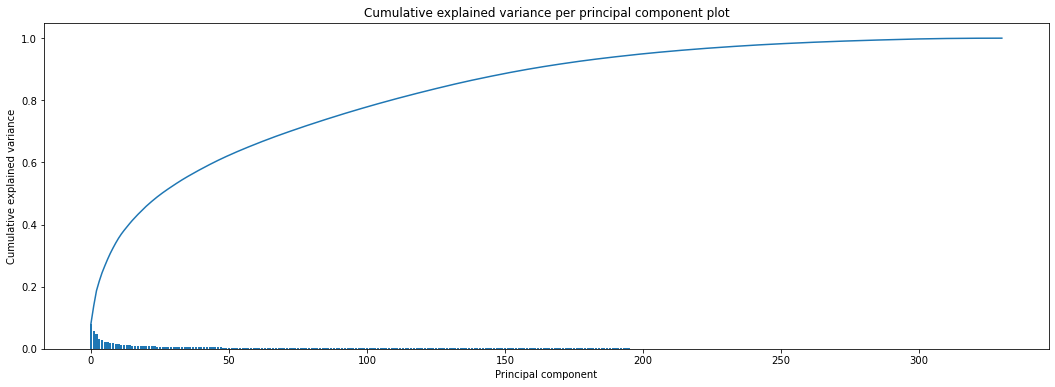

In [74]:
# Principal Component Analysis on Dataset. Fit the model with data and apply the dimensionality reduction on data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_transformed)
fig = pca_scree_plot(pca)
fig.savefig('scree_plot.png', dpi=500)

At around the 175-th principal component, the explained variance drops off close to zero.

In [75]:
n_component = 195
print("Explained variance ratio for the first {} components is {}%".format(n_component, sum(pca.explained_variance_ratio_[:n_component]).round(2)*100))

Explained variance ratio for the first 195 components is 94.0%


The first 195 components will describe 94% of the data variance out of a total of 331 features.

In [76]:
pca = PCA(n_component)

azdias_pca_reduced = pca.fit_transform(azdias_transformed)
explained_variance_ratio = sum(pca.explained_variance_ratio_)

print("azdias_pca_reduced shape: {}".format(azdias_pca_reduced.shape))
print("explained variance ratio percentage: {}".format(explained_variance_ratio.round(2)*100))

azdias_pca_reduced shape: (737208, 195)
explained variance ratio percentage: 94.0


**Mapping PCA components to column names**

In [77]:
top_three_pca = pca.explained_variance_ratio_[:3]
print("The first 3 components accounts for {}% of the data variance.".format(top_three_pca.sum().round(3) * 100))

The first 3 components accounts for 18.7% of the data variance.


In [78]:
def map_component_to_features(pca, component, column_names):
    """
    Input:
    pca (object) : object of PCA class
    component (int) : number of components to map to features
    column_names (list(str)) : column names of azdias before PCA transformation
    
    Output:
    df_features (dataframe) : dataframe with attribute names and attribute PCA weighting
    """
    weights_array = pca.components_[component]
    df_features = pd.DataFrame(weights_array, index=column_names, columns=['weight'])
    df_features = df_features.sort_values(by=['weight'], ascending=False)
    return df_features    

In [79]:
print("The first component explains {}% of the variance in the data and is determined largely by the following features:".format(top_three_pca[0].round(3)*100))
map_component_to_features(pca, 0, azdias_transformed.columns).head()

The first component explains 8.1% of the variance in the data and is determined largely by the following features:


,weight
ANZ_HAUSHALTE_AKTIV,0.148029
KBA13_ANTG3,0.147887
KBA13_ANTG4,0.145582
KBA13_BAUMAX,0.145405
PLZ8_BAUMAX,0.143571


In [80]:
print("The first component is negatively influenced by the following features:")
map_component_to_features(pca, 0, azdias_transformed.columns).tail()

The first component is negatively influenced by the following features:


,weight
MOBI_RASTER,-0.141011
LP_STATUS_GROB,-0.142993
KBA05_ANTG1,-0.145942
KBA13_ANTG1,-0.149726
MOBI_REGIO,-0.157366


This shows that component 1 is mainly determined by number of households in a building and size of family in a house.

In [81]:
print("The second component explains {}% of the variance in the data and is determined largely by the following features:".format(top_three_pca[1].round(3)*100))
map_component_to_features(pca, 1, azdias_transformed.columns).head()

The second component explains 5.7% of the variance in the data and is determined largely by the following features:


,weight
KBA13_HERST_BMW_BENZ,0.188410
KBA13_SEG_OBEREMITTELKLASSE,0.162117
KBA13_MERCEDES,0.160805
KBA13_BMW,0.157176
KBA13_SITZE_4,0.148354


In [82]:
print("The second component is negatively influenced by the following features:")
map_component_to_features(pca, 1, azdias_transformed.columns).tail()

The second component is negatively influenced by the following features:


,weight
KBA13_HALTER_25,-0.121193
KBA13_KMH_180,-0.122829
KBA13_SEG_KLEINWAGEN,-0.135079
KBA13_KMH_140_210,-0.135196
KBA13_SITZE_5,-0.151770


This shows that component 2 is mainly determined by luxury and expensive cars owned.

In [83]:
print("The third component explains {}% of the variance in the data and is determined largely by the following features:".format(top_three_pca[2].round(3)*100))
map_component_to_features(pca, 2, azdias_transformed.columns).head()

The third component explains 4.9% of the variance in the data and is determined largely by the following features:


,weight
PRAEGENDE_JUGENDJAHRE,0.221305
CJT_TYP_1,0.208153
FINANZ_SPARER,0.203782
CJT_TYP_2,0.200991
FINANZ_ANLEGER,0.183331


In [84]:
print("The third component is negatively influenced by the following features:")
map_component_to_features(pca, 2, azdias_transformed.columns).tail()

The third component is negatively influenced by the following features:


,weight
CJT_TYP_3,-0.177394
CJT_TYP_4,-0.185471
ALTERSKATEGORIE_GROB,-0.189030
CJT_TYP_5,-0.190569
FINANZ_VORSORGER,-0.194264


This shows that component 3 is mainly determined by age and financial status.

## K-Means Clustering

To find a K value, we start by selecting a range of centers value (K value). Then we compute the sum of squared error for the all the centers value/K value. Sum of squared error(SSE) is defined as the sum of the squared distance between each centroid and each member of the cluster. We then plot the centers value/K value against the SSE. Based on the plot, we should be able to observe that as K increases, SSE decreases. Hence, the idea of the algorithm is to choose the value of K at which the graph decreases abruptly - this produces the so-called "elbow effect".

In [85]:
def get_kmeans_score(data, center, batch_size=20000):
    '''
    returns the kmeans score. This is the sum of the squared error for all the centers value.
    Input:
        data (dataframe) : the dataset you want to fit kmeans to
        center (int) : the number of centers in the distribution (or equivalent to the K value)
    
    Output:
        score (int) : the sum of the squared error for kmeans model fit to the data
    '''
    kmeans = MiniBatchKMeans(n_clusters=center, batch_size=batch_size, random_state=0)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [86]:
batch_size = 40000
scores = []
centers = list(range(1, 31, 1))

for center in centers:
    print(center)
    scores.append(get_kmeans_score(azdias_pca_reduced, center, batch_size))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


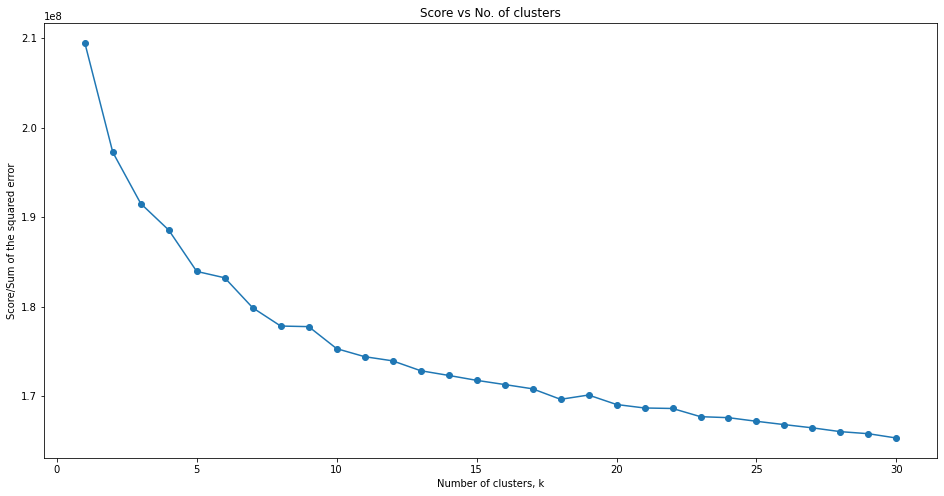

In [87]:
plt.figure(figsize=(16,8))
plt.plot(centers, scores, '-o')
plt.xlabel("Number of clusters, k")
plt.ylabel("Score/Sum of the squared error")
plt.title("Score vs No. of clusters")
plt.savefig('elbow_diagram.png', dpi=500)

To determine the optimal number of clusters, we select k=8, because at this point, we can see a slight elbow forming.

## Clean customers dataset, transform, perform PCA and K-Means clustering

In [88]:
# Set PCA and KMeans parameters and pipeline
n_components = 195
n_clusters = 8
cluster_pipeline = Pipeline([
    ('transform', column_transformer),
    ('pca', PCA(n_components)),
    ('kmeans', KMeans(n_clusters, random_state=0))
])

In [89]:
# Fit cluster pipeline to general population & create clustered general population dataframe
cluster_pipeline.fit(azdias_cleaned)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_cleaned), columns=['Cluster'])

In [90]:
# Create clustered customers dataframe
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_cleaned), columns=['Cluster'])

In [91]:
azdias_clustered.to_pickle('azdias_clustered')
customers_clustered.to_pickle('customers_clustered')
azdias_clustered = pd.read_pickle('azdias_clustered')
customers_clustered = pd.read_pickle('customers_clustered')

**Comparison of proportion of clustered datapoints for general population and customers clusters**

In [92]:
general_clusters = azdias_clustered['Cluster'].value_counts().sort_index()

In [93]:
general_clusters

0     96535
1    107942
2    127202
3     95450
4    125225
5     77525
6     52002
7     55327
Name: Cluster, dtype: int64

In [94]:
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

In [95]:
customer_clusters

0     3108
1    18001
2     1713
3    28329
4    49004
5    27721
6     3761
7     2608
Name: Cluster, dtype: int64

In [96]:
clusters = pd.concat([general_clusters, customer_clusters], axis=1).reset_index()

In [97]:
clusters.columns = ['cluster', 'general_count', 'customers_count']

In [98]:
clusters

,cluster,general_count,customers_count
0,0,96535,3108
1,1,107942,18001
2,2,127202,1713
3,3,95450,28329
4,4,125225,49004
5,5,77525,27721
6,6,52002,3761
7,7,55327,2608


In [99]:
clusters['general_share'] = ( clusters['general_count'] / clusters['general_count'].sum() ) * 100
clusters['customers_share'] = ( clusters['customers_count'] / clusters['customers_count'].sum() ) * 100
clusters['difference'] = clusters['customers_share'] - clusters['general_share']

**Plot of clusters**

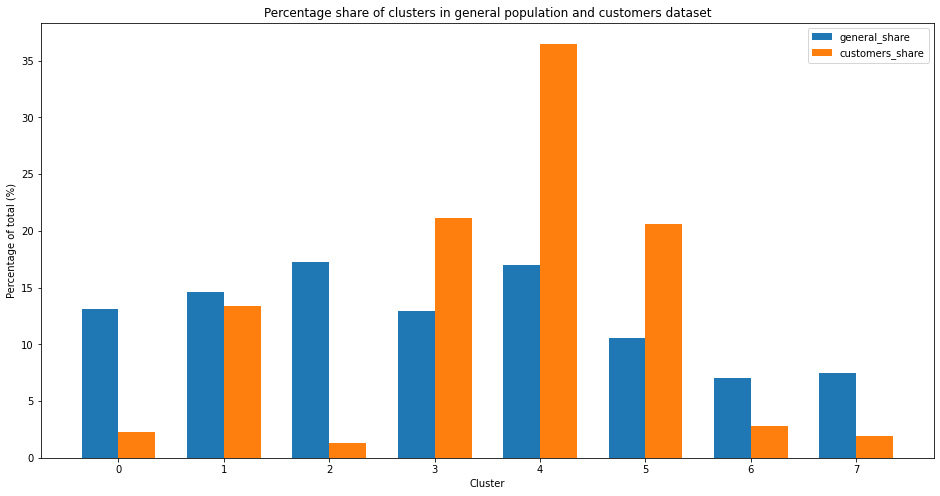

In [100]:
fig, ax = plt.subplots(figsize=(16, 8))
index = np.arange(n_clusters)
bar_width = 0.35

ax.bar(index, clusters['general_share'], bar_width, label='general_share')
ax.bar(index+bar_width, clusters['customers_share'], bar_width, label='customers_share')

ax.set_xlabel("Cluster")
ax.set_ylabel("Percentage of total (%)")
ax.set_title("Percentage share of clusters in general population and customers dataset")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()
plt.savefig('share_of_clusters.png', dpi=500)

**Plot of cluster differences**

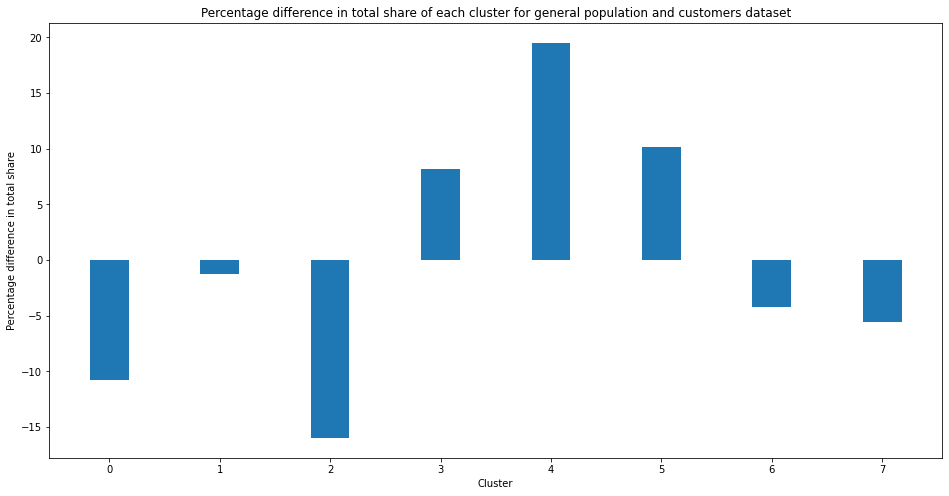

In [101]:
fig, ax = plt.subplots(figsize=(16, 8))
index = np.arange(n_clusters)
bar_width = 0.35

ax.bar(index, clusters['difference'], bar_width)
ax.set_xlabel("Cluster")
ax.set_ylabel("Percentage difference in total share")
ax.set_title("Percentage difference in total share of each cluster for general population and customers dataset")
ax.set_xticks(index)
ax.set_xticklabels(index)

plt.savefig('cluster_difference.png', dpi=500)

Clusters 4 and 5 are positively-represented while clusters 0 and 2 are negatively-represented.

**Obtain cluster attributes**

In [102]:
def get_clusters_attributes(cluster_pipeline, numerical_columns, column_names):
    '''
    Input:
        cluster_pipeline (object) : object of cluster_pipeline
        num_attributes (list): list of numerical attributes which were rescaled
        log_attributes (list): list of attributes which has logarithmic transformation and also were rescaled
        column_names (list): names of all columns after Column Transformer operation
    
    Output:
        cluster_centers_df (dataframe): Dataframe of cluster_centers with their attributes values
    '''
    pca_components = cluster_pipeline.named_steps['pca']
    kmeans = cluster_pipeline.named_steps['kmeans']
    transformer = cluster_pipeline.named_steps['transform']
    
    cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(data=cluster_centers, columns=column_names)
    
    num_scale = transformer.named_transformers_['numerical'].named_steps['numerical_scale']
    
    cluster_centers_df[numerical_columns] = num_scale.inverse_transform(cluster_centers_df[numerical_columns])
    
    return cluster_centers_df

In [103]:
cluster_centers_df = get_clusters_attributes(cluster_pipeline, numerical_columns, column_names)

In [104]:
cluster_centers_df

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,...,KBA13_MAZDA,KBA05_KRSZUL,KBA05_CCM2,SEMIO_ERL,D19_BEKLEIDUNG_GEH,KBA05_KRSHERST3,KBA13_CCM_1800,KBA05_KRSHERST1,PLZ8_BAUMAX,KBA13_HERST_SONST
0,0.999460,-0.282291,-0.596771,-0.254483,0.995648,0.080843,0.071494,0.087445,0.624747,0.765747,...,3.125882,1.688776,2.937132,3.808336,0.286016,3.076011,2.312812,2.765667,4.046248,3.236558
1,0.614808,-0.289307,-0.027189,-0.267751,0.997304,0.068786,0.076180,0.068403,0.301879,0.882086,...,3.295465,1.814520,3.064375,5.489583,0.237140,3.269990,2.280266,2.663526,2.332326,2.769325
2,0.034033,-0.198149,0.346625,-0.057077,0.995707,0.128048,0.081619,0.103719,0.169900,0.940964,...,3.028835,1.893562,2.973828,3.640178,0.192855,3.120049,2.383747,2.826624,1.236788,2.662176
3,-0.821670,1.071158,0.282093,0.276210,0.991761,0.442794,0.149813,0.148463,0.075612,0.933339,...,2.884712,2.031829,2.897295,4.528717,1.616692,3.033271,2.416574,3.013505,1.091643,2.627607
4,-0.756894,-0.073739,0.312114,0.029803,0.991288,0.344914,0.094545,0.143026,0.080854,0.959235,...,2.859219,2.012792,2.920771,5.379094,0.390554,3.047480,2.424908,3.015314,1.037183,2.582584
5,-0.065930,-0.065266,0.034563,-0.183595,0.998953,0.522286,0.092915,0.288051,0.340265,0.936008,...,2.804753,2.169222,2.625423,4.736820,0.738054,2.473867,2.264385,3.620278,1.968114,3.231222
6,-0.645503,0.145973,-0.531051,0.665079,0.937901,0.121668,0.087104,0.061709,0.042015,0.150205,...,3.279836,1.952760,3.308514,4.816300,0.403365,3.037126,2.414329,2.950180,1.088893,3.992681
7,0.810039,-0.215000,-0.446098,0.185421,0.972508,0.018447,0.063109,0.018850,0.258163,0.068636,...,3.873420,1.905612,3.622970,4.707816,0.213011,3.114230,2.401220,2.661896,3.454403,3.969672


In [105]:
positive_cluster1 = 4
positive_cluster2 = 5
negative_cluster1 = 0
negative_cluster2 = 2

comparison_df = cluster_centers_df.T[[4, 5, 0, 2]]
comparison_df.columns = ['positive_cluster1', 'positive_cluster2', 'negative_cluster1', 'negative_cluster2']

In [106]:
comparison_df_std = comparison_df[comparison_df.std(axis=1) > 1]

In [107]:
comparison_df_std

,positive_cluster1,positive_cluster2,negative_cluster1,negative_cluster2
ANZ_STATISTISCHE_HAUSHALTE,2.234183,6.872080,16.062857,5.814821
HH_EINKOMMEN_SCORE,3.428707,3.582609,5.609253,4.862961
SEMIO_REL,2.948076,3.498428,5.197501,5.431387
CJT_TYP_5,4.359608,3.522882,2.178142,2.065598
EWDICHTE,2.862775,4.934159,5.774976,3.588748
FINANZ_ANLEGER,1.957603,1.960719,3.304043,4.076545
FINANZ_SPARER,1.446380,2.240616,3.932492,4.140664
CJT_TYP_2,1.790810,2.866600,4.343586,4.316408
FINANZ_VORSORGER,4.548210,3.795755,2.560997,2.336631
EINGEZOGENAM_HH_JAHR,2000.723413,2003.341237,2006.233312,2006.551229


Observing the positive and negative clusters for the highest difference between them, we can identify attributes of groups of people that would be positively interested by the marketing, as well as those negatively interested by it.

The positively interested clusters are those that have the following attributes:
- financially prepared with savings
- financially lean with good budget
- religiously inclined
- they are of the 60s - 80s generation
- they have relatively high income
- they are mostly established and consumption minded middle class
- they are slightly above the average income earners
- they are people with investments and are typically money savers
- they are traditional-minded
- low movement pattern, indicating they live in a house they own

The negatively interested clusters are those that have the following attributes:
- very low savings and people who do not invest
- low income earners
- less religiously inclined
- they are of the 80s and above generation and most likely to be a member of the Communist Party Youth Organisation
- they are less traditionally inclined
- high movement pattern, indicating the person does not live in a house they own

In [108]:
comparison_df.to_pickle('comparison_df')

In [109]:
comparison_df = pd.read_pickle('comparison_df')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [110]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [111]:
mailout_train.shape

(42962, 367)

In [112]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [114]:
mailout_train_cleaned = clean_data(mailout_train, missing_keys_dict, test_data=True)

In [115]:
print(mailout_train_cleaned.shape)

(42962, 311)


In [116]:
print(mailout_train_cleaned.dtypes.value_counts())

float64    246
int64       64
object       1
dtype: int64


In [117]:
X_train = mailout_train_cleaned.drop(['RESPONSE'], axis=1)
y_train = mailout_train_cleaned['RESPONSE']

In [118]:
models = {'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': xgb.XGBClassifier()
         }

In [119]:
def randomize(X, y):
    X2 = pd.concat([X,y], axis=1)
    X2 = X2.sample(frac=1, random_state=0)
    y2 = X2['RESPONSE']
    X2 = X2.drop(['RESPONSE'], axis=1)
    
    return X2, y2

In [120]:
def plot_learning_curves(X, y, estimator, n_trainings):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=np.linspace(.1, 1.0, n_trainings), cv=None, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    roc_auc_train_score = train_scores_mean[-1].round(2)
    roc_auc_validation_score = test_scores_mean[-1].round(2)
    
    print("ROC_AUC Train Score: {}".format(roc_auc_train_score))
    print("ROC_AUC Validation/Test Score: {}".format(roc_auc_validation_score))
    
    plt.grid()
    plt.xlabel("Percentage of training")
    plt.ylabel("Score")
    plt.title("Learning curves")
    plt.plot(np.linspace(0.1, 1.0, n_trainings)*100, train_scores_mean, 'o-', color='b', label='train' )
    plt.plot(np.linspace(0.1, 1.0, n_trainings)*100, test_scores_mean, 'o-', color='g', label='test' )
    
    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.show()

The pipeline consists of two parts, a transformer from the pre-processing section of this project and a classifier:

RandomForestClassifier
ROC_AUC Train Score: 0.97
ROC_AUC Validation/Test Score: 0.61


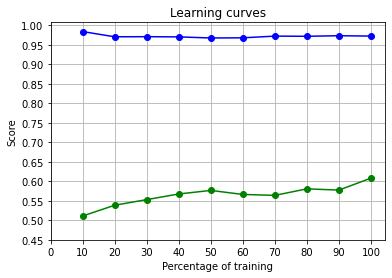

AdaBoostClassifier
ROC_AUC Train Score: 0.84
ROC_AUC Validation/Test Score: 0.73


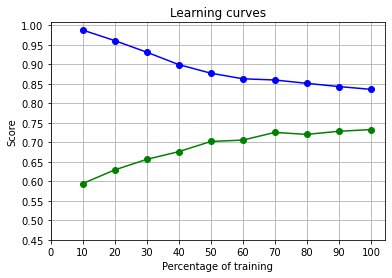

GradientBoostingClassifier
ROC_AUC Train Score: 0.91
ROC_AUC Validation/Test Score: 0.75


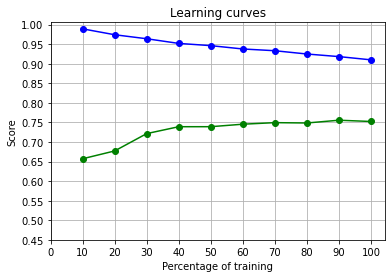

XGBClassifier
ROC_AUC Train Score: 0.99
ROC_AUC Validation/Test Score: 0.68


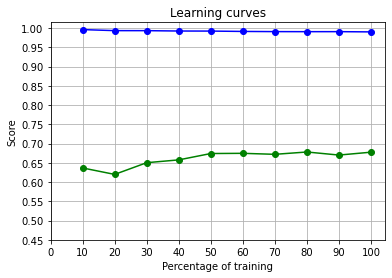

In [121]:
for model_key in models.keys():
    print(model_key)
    ml_pipeline = Pipeline([
        ('transform', column_transformer),
        ('model', models[model_key])
    ])
    X2, y2 = randomize(X_train, y_train)
    plot_learning_curves(X2, y2, ml_pipeline, 10)

The RandomForestClassifier and XGBoostClassifier is a high bias model in this instance as the train and test curve does not seem to converge even with additional data. This means both estimators are overfitting the model and hence badly predicts new data.

The AdaBoostClassifier is slightly better as the train and test curve seems to converge with the addition data. However, the test curve appears to have plateaued and does not seem to converge anymore towards the end of the test curve.

The GradientBoostingClassifier is far better as the train and test curve seems to converge with the addition of data. Moreover there is the possibility that the model will converge further if more data is provided. Also, it's validation score is higher than AdaBoostClassifier. Hence, we will select GradientBoostingClassifier as our estimator.

## Grid Search

GridSearch performs an exhaustive search over specified parameter values for an estimator. It will then select the model with parameters that yield the best validation score.

In [122]:
# Create pipeline with column transformer and gradient boosting classifier for grid search
gbc_pipeline = Pipeline([
    ('transform', column_transformer),
    ('gbc', GradientBoostingClassifier(random_state=0))
])

# define parameters appropriate for an exhaustive iterative search of the best parameters
parameters = { 'gbc__learning_rate': [0.1, 0.2], 'gbc__n_estimators': [100], 
              'gbc__max_depth': [3, 5], 'gbc__min_samples_split': [2, 4] }

# instantiate grid search
grid_obj = GridSearchCV(gbc_pipeline, parameters, scoring='roc_auc')

# fit the grid search object to training data to find the best parameters
grid_obj.fit(X_train, y_train)

# get the estimator and predict based on the best parameters
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X_train)[:, 1]

# predict based on the default parameters
predictions = (gbc_pipeline.fit(X_train, y_train)).predict_proba(X_train)[:, 1]

print("ROC score: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

{'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__min_samples_split': 4, 'gbc__n_estimators': 100}
ROC score: 0.8978
Final ROC score: 0.8981


In [123]:
pkl_filename = 'best_gradient_boosting.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_clf, file)

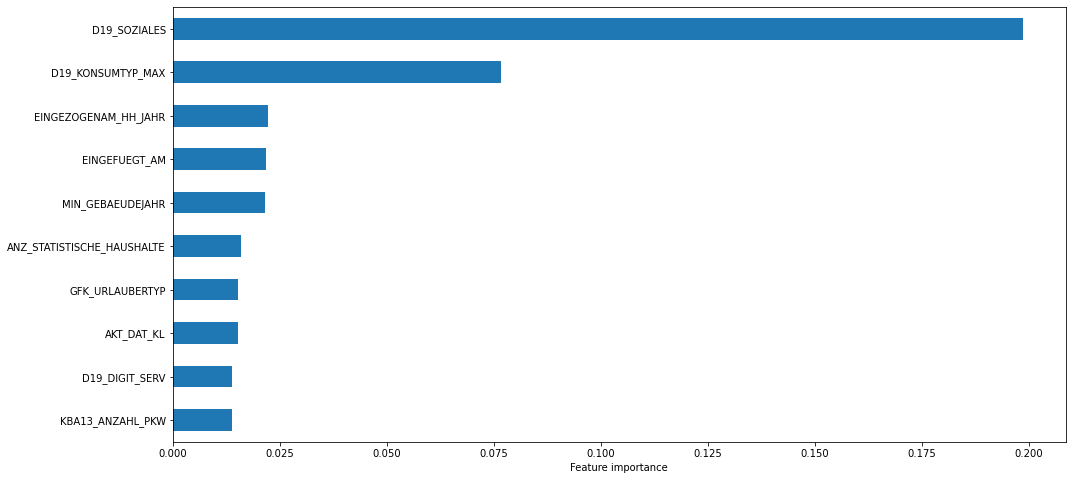

In [124]:
feature_importances = best_clf.named_steps['gbc'].feature_importances_
pd.Series(feature_importances, index=column_names).sort_values()[-10:].plot(kind='barh', figsize=(16, 8))
plt.xlabel("Feature importance")
plt.savefig('feature_importance.png', dpi=500)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [125]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

In [126]:
mailout_test.shape

(42833, 366)

In [127]:
mailout_test_cleaned = clean_data(mailout_test, missing_keys_dict, test_data=True)

In [128]:
# check that dataset is the same
mailout_test_cleaned = mailout_test_cleaned[mailout_train_cleaned.drop(['RESPONSE'], axis=1).columns]

In [129]:
print(mailout_train_cleaned.drop(['RESPONSE'], axis=1).shape)
print(mailout_test_cleaned.shape)

(42962, 310)
(42833, 310)


In [130]:
pkl_filename = 'best_gradient_boosting.pkl'

with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

kaggle_predict = pickle_model.predict_proba(mailout_test_cleaned)[:,1]
kaggle_predict

array([0.04380394, 0.02599756, 0.00293027, ..., 0.02821888, 0.03872202,
       0.02212874])

In [131]:
submission = pd.read_csv('Arvato_Capstone_Example_Submission.csv')
submission['RESPONSE'] = kaggle_predict
submission.to_csv('kaggle_submission.csv', index=False)
submission.shape

(42833, 2)

In [132]:
submission.head()

,LNR,RESPONSE
0,1754,0.043804
1,1770,0.025998
2,1465,0.002930
3,1470,0.003441
4,1478,0.015672


#### The Kaggle score on the test data set is 0.78556.